# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [4]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train.shape[1]

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32
Number of classes = 43


Let's take a quick look at the distribution of the classes:

(array([  185.,  1997.,  2026.,  1264.,  1780.,  1677.,   369.,  1303.,
         1277.,  1333.,  1803.,  1183.,  1890.,  1956.,   716.,   564.,
          375.,   999.,  1072.,   197.,   330.,   292.,   342.,   456.,
          237.,  1359.,   531.,   217.,   500.,   241.,   412.,   709.,
          211.,   622.,   381.,  1076.,   341.,   191.,  1846.,   268.,
          334.,   426.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.]),
 <a list of 42 Patch objects>)

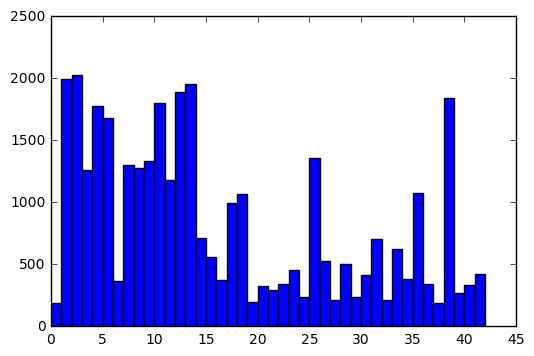

In [104]:
import matplotlib.pyplot as plt
plt.hist(y_train,bins=max(set(y_train)))

In [7]:
import numpy as np
import matplotlib.gridspec as gridspec
from itertools import product
%matplotlib inline

print("Training data shape = ", X_train.shape)
print("Number of channels in each image = ", X_train.shape[3])

#Print out single image
def plot_image(img, width, height):
    fig = plt.figure(1, (width, height))
    plt.imshow(img)
    plt.axis('off')
    return plt

# Print out images in rows of length n_col
def plot_images(images, n_cols, grayscale = False):
    n_rows = int(np.ceil(len(images) / n_cols))
    fig = plt.figure(figsize=(n_cols, n_rows))
    gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.0, hspace=0.0)
    for i, xy in enumerate(product(range(0,n_rows), range(0,n_cols))):
        ax = plt.subplot(gs[xy[0], xy[1]])
        if grayscale:
            ax.imshow(images[i], cmap='gray')
        else:
            ax.imshow(images[i])
            
        ax.set_xticks([])
        ax.set_yticks([])

# Return a sample of image indexes based on the class
def sample_indices(images, image_class, n_sample):
    n_classes = len(set(image_class))
    indices = np.arange(0,len(images))
    result = np.empty(0,dtype=int)
    for i in range(0,n_classes):
        bidx = (image_class == i)
        class_indices = indices[bidx]
        n_images = len(class_indices)
        sample_indices = np.random.choice(class_indices,n_sample)
        result = np.concatenate((result, sample_indices))
    return result
    
idx = sample_indices(X_train, y_train, 10)

#plot_images(X_train[idx,:,:,:], 10)

Training data shape =  (39209, 32, 32, 3)
Number of channels in each image =  3


Here are some challenges we can see in this data set:

* Class imbalance
* Poor quality images - due to:
    * motion blur
    * low light conditions
    * low contrast images
    * high exposure images
    * obstruction due to shadows
    * obstruction due to graffiti

Here are some observations that may inform choice of data preprocessing and machine learning approach:

* All images contain traffic signs - so we are only concerned with classification not detection
* The signs are largely centred in the image
* The data already contains transformed (jittered) versions of images which will help when training deep convolutional networks.


With more time I would like to do the following data visualizations:

* Boxplots of RGB values by class - to ensure that images of certain signs are not clustered in RGB space 

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
import cv2

def normalize_grayscale(image_data, rng = (0.1, 0.9)):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = rng[0]
    b = rng[1]
    x_min = np.min(image_data)
    x_max = np.max(image_data)
    return a + (((image_data - x_min)*(b - a))/(x_max - x_min))

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Create gray training and test set.
X_train_gray = np.empty( [n_train, image_shape, image_shape], dtype = np.int32)
for i, img in enumerate(X_train):
    X_train_gray[i,:,:] = normalize_grayscale(grayscale(img), (0, 254) )
    
#plot_images(X_train_gray[idx,:,:], 10, grayscale = True)

That was not what I expected!  We actually need to perform a histogram normalisation.

In [9]:
# Training data
X_train_gray = np.empty( [n_train, image_shape, image_shape], dtype = np.int32)
for i, img in enumerate(X_train):
    X_train_gray[i,:,:] = cv2.equalizeHist(grayscale(img), (0, 254) )
    
#plot_images(X_train_gray[idx,:,:], 10, grayscale = True)

Looking good! We will start with normalised grayscale images. We could also use Contrast Limited Adaptive Histogram Equalization - to avoid over exposire in parts of the image.  Later we can retain color and try normalising in YUV space like the paper talks about - since color is likely an important predictor.

```
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
```

Let's also normalise the test data:

In [10]:
# Test data
X_test_gray = np.empty( [n_test, image_shape, image_shape], dtype = np.int32)
for i, img in enumerate(X_test):
    X_test_gray[i,:,:] = cv2.equalizeHist(grayscale(img), (0, 254) )

We also need to create a validation dataset.   Here I take 10% of the test data for validation during training.  We will reserve the test data for model performance evaluation - it will play no part in the training of the models.

Note - the default conda environment did not have correct version of scikit-learn - needed `conda install scikit-learn` to fix.  Helped by this [post](https://github.com/scikit-learn/scikit-learn/issues/6161).

In [11]:
from sklearn.model_selection import train_test_split

X_train_gray, X_valid_gray, y_train, y_valid = train_test_split(
    X_train_gray,
    y_train,
    test_size=0.10,
    random_state=1973)

Before we can get going the training and test labels require one-hot encoding:

In [12]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
valid_labels = encoder.transform(y_valid)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
valid_labels = valid_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

In [13]:
print(X_train_gray.shape)
print(X_valid_gray.shape)
print(X_test_gray.shape)

(35288, 32, 32)
(3921, 32, 32)
(12630, 32, 32)


We need to flatten our input features - currently 32 x 32 to a vector of length 1024:

In [14]:
def flatten_all_gray(images):
    images_flat = []
    for i, img in enumerate(images):
        images_flat.append(np.array(images[i,:,:], dtype=np.float32).flatten())
    return np.array(images_flat)
    
X_train_gray_flat = flatten_all_gray(X_train_gray)
X_valid_gray_flat = flatten_all_gray(X_valid_gray)
X_test_gray_flat = flatten_all_gray(X_test_gray)

We need to normalise features for models into range 0.1 to 0.9

In [15]:
X_train_gray_flat = normalize_grayscale(X_train_gray_flat)
X_valid_gray_flat = normalize_grayscale(X_valid_gray_flat)
X_test_gray_flat = normalize_grayscale(X_test_gray_flat)

Plans for model architecture:

* Start with simple linear classifier on the data directly - like the lab - just to check tensorflow API out.
* Then make deeper traditional multi-layer neural networks
* Finally we will build a convnet

We will use stochastic gradient descent (minibatch).   Output layers to all networks will apply softmax to logits to get probability distribution across the multiple classes.   We will use the cross entropy error function.  Between hidden layers we will include relus.

### Linear Classifier

Lets start with linear classifier - single layer implementing a simple Linear Function WX + b:

In [41]:
import tensorflow as tf

features_count = 32 * 32

features = tf.placeholder(tf.float32, [None, features_count])
labels = tf.placeholder(tf.float32, [None, n_classes]) 

weights = tf.Variable(tf.truncated_normal(stddev=0.1, dtype=tf.float32, shape=[features_count, n_classes]))
biases = tf.Variable(tf.zeros([n_classes]))

from tensorflow.python.ops.variables import Variable

train_feed_dict = {features: X_train_gray_flat, labels: train_labels}
valid_feed_dict = {features: X_valid_gray_flat, labels: valid_labels}
test_feed_dict = {features: X_test_gray_flat, labels: test_labels}

logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)
predicted_class = tf.argmax(prediction, dimension=1)

cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)
loss = tf.reduce_mean(cross_entropy)

init = tf.initialize_all_variables()

with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)
    
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

Configuration 1
* **Epochs:**
  * 1 = 0.48
  * 2 = 0.63
  * 3 = 0.68
  * 4 = 0.71
  * 5 = 0.75
  * 6 = 0.76
  * 7 = 0.79
  * 8 = 0.81
  * 16 = 0.86
  * 64 = 0.91
* **Batch Size:** 100
* **Learning Rate:** 0.2



100%|██████████| 64/64 [03:49<00:00,  3.32s/epochs]


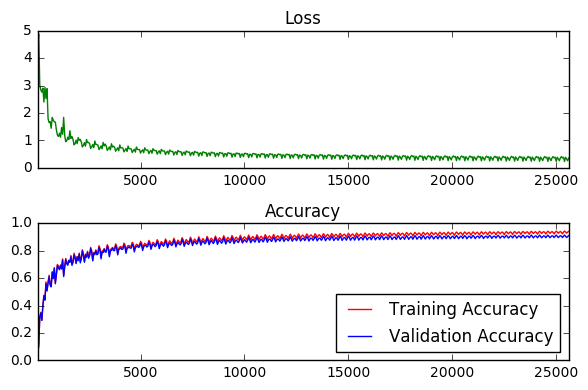

Validation accuracy at 0.9099719524383545


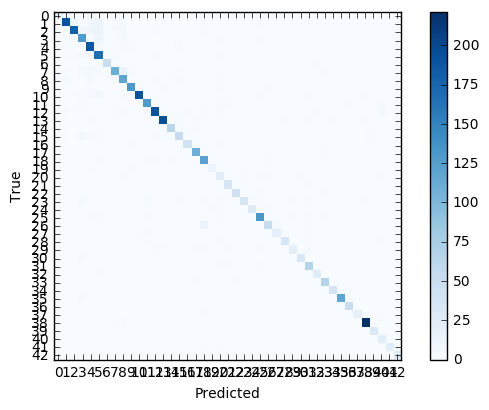

In [43]:
import math
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# ToDo: Find the best parameters for each configuration
epochs = 64
batch_size = 100
learning_rate = 0.2

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(X_train_gray_flat)/batch_size))

    epoch_pbar = tqdm(range(epochs), unit='epochs')
    for epoch_i in epoch_pbar:
        
        # The training cycle
        for batch_i in range(batch_count):
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = X_train_gray_flat[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
        # Get predicted class
        y_pred = session.run(predicted_class, feed_dict=valid_feed_dict)
        
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()


cm = confusion_matrix(y_true=y_valid,
                          y_pred=y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, range(n_classes))
plt.yticks(tick_marks, range(n_classes))
plt.xlabel('Predicted')
plt.ylabel('True')

print('Validation accuracy at {}'.format(validation_accuracy))

Surprisingly good accuracy for such a simple network.  Let's add a hidden layer.

### Single Hidden Layer

Here we implement a single hidden layer of width 200.  Also I updated the code to include **early stopping**.  Easier to let the network train for many iterations - stopping if no improvement after a specified number of iterations.

In [16]:
import tensorflow as tf
from tensorflow.python.ops.variables import Variable

features_count = 32 * 32
n_hidden_layer = 200

features = tf.placeholder(tf.float32, [None, features_count])
labels = tf.placeholder(tf.float32, [None, n_classes]) 

weights = {
    'hidden_layer': tf.Variable(tf.random_normal(shape=[features_count, n_hidden_layer], stddev=0.05, dtype=tf.float32)),
    'output_layer': tf.Variable(tf.random_normal(shape=[n_hidden_layer, n_classes], stddev=0.05, dtype=tf.float32))
}
biases = {
    'hidden_layer': tf.Variable(tf.random_normal(shape=[n_hidden_layer], stddev=0.05, dtype=tf.float32)),
    'output_layer': tf.Variable(tf.random_normal(shape=[n_classes], stddev=0.05, dtype=tf.float32))
}

out = tf.add(tf.matmul(features, weights['hidden_layer']), biases['hidden_layer'])
out = tf.nn.relu(out)
logits = tf.matmul(out, weights['output_layer']) + biases['output_layer']
prediction = tf.nn.softmax(logits)
predicted_class = tf.argmax(prediction, dimension=1)

train_feed_dict = {features: X_train_gray_flat, labels: train_labels}
valid_feed_dict = {features: X_valid_gray_flat, labels: valid_labels}
test_feed_dict = {features: X_test_gray_flat, labels: test_labels}

cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)
loss = tf.reduce_mean(cross_entropy)

init = tf.initialize_all_variables()

with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)
    
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

  5%|▍         | 96/2000 [15:40<4:23:43,  8.31s/epochs]

Stopping no improvement for 10 epochs


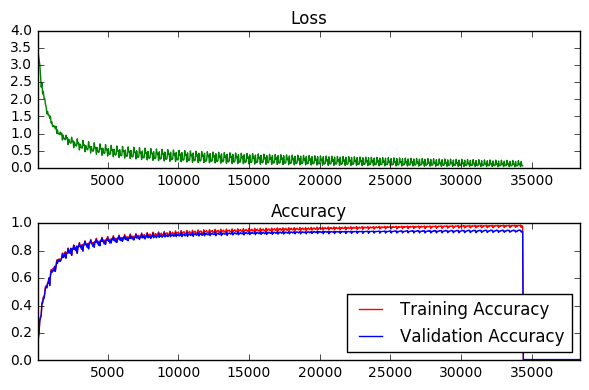

Validation accuracy at 0.9461871981620789


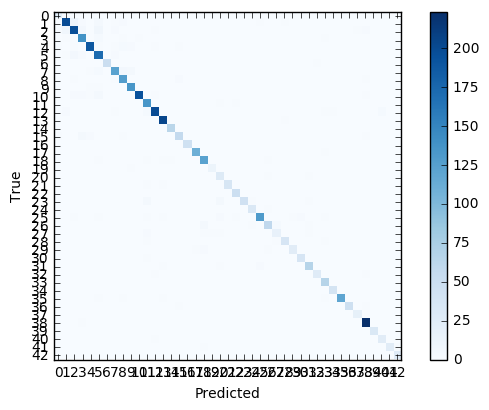

In [37]:
import math
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

epochs = 2000
batch_size = 100
learning_rate = 0.05

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# Early stopping parameters
early_stopping_rounds = 10

# For saving the tensorflow variables
saver = tf.train.Saver()

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(X_train_gray_flat)/batch_size))

    # Early stopping flags
    epoch_i = 0
    continue_training = True
    consider_stopping = False
    epochs_since_better = 0
    best_accuracy = 0.0
    
    with tqdm(range(epochs), unit='epochs') as pbar: 
        while epoch_i < epochs and continue_training:
            batch_i = 0
            while batch_i < batch_count and continue_training:

                # Get a batch of training features and labels
                batch_start = batch_i*batch_size
                batch_features = X_train_gray_flat[batch_start:batch_start + batch_size]
                batch_labels = train_labels[batch_start:batch_start + batch_size]

                # Run optimizer and get loss
                _, l = session.run(
                    [optimizer, loss],
                    feed_dict={features: batch_features, labels: batch_labels})

                # Log every 50 batches
                if not batch_i % log_batch_step:
                    # Calculate Training and Validation accuracy
                    training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                    validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                    # Log batches
                    previous_batch = batches[-1] if batches else 0
                    batches.append(log_batch_step + previous_batch)
                    loss_batch.append(l)
                    train_acc_batch.append(training_accuracy)
                    valid_acc_batch.append(validation_accuracy)

                batch_i += 1
                
            # Check accuracy against Validation data
            validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
            # Get predicted class
            y_pred = session.run(predicted_class, feed_dict=valid_feed_dict)

            # Early stopping?
            if validation_accuracy < best_accuracy:    
                if consider_stopping:
                    epochs_since_better += 1
                else:
                    consider_stopping = True
                    epochs_since_better = 1
            else:
                best_accuracy = validation_accuracy
                saver.save(session, "model.ckpt")
                consider_stopping = False

            if epochs_since_better > early_stopping_rounds:
                    print('Stopping no improvement for {} epochs'.format(early_stopping_rounds))
                    continue_training = False

            epoch_i += 1
            pbar.update(1)
        
    # Restore best model
    saver.restore(session, "model.ckpt")
    # Check accuracy against Validation data
    validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
    # Get predicted class
    y_pred = session.run(predicted_class, feed_dict=valid_feed_dict)
        
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_true=y_valid,
                          y_pred=y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, range(n_classes))
plt.yticks(tick_marks, range(n_classes))
plt.xlabel('Predicted')
plt.ylabel('True')

print('Validation accuracy at {}'.format(validation_accuracy))

Which images are not being classified correctly?  Here we display images that are misclassified into a class - the first two images represent correct classifications, followed by 8 images that we incorrectly classified as the same:

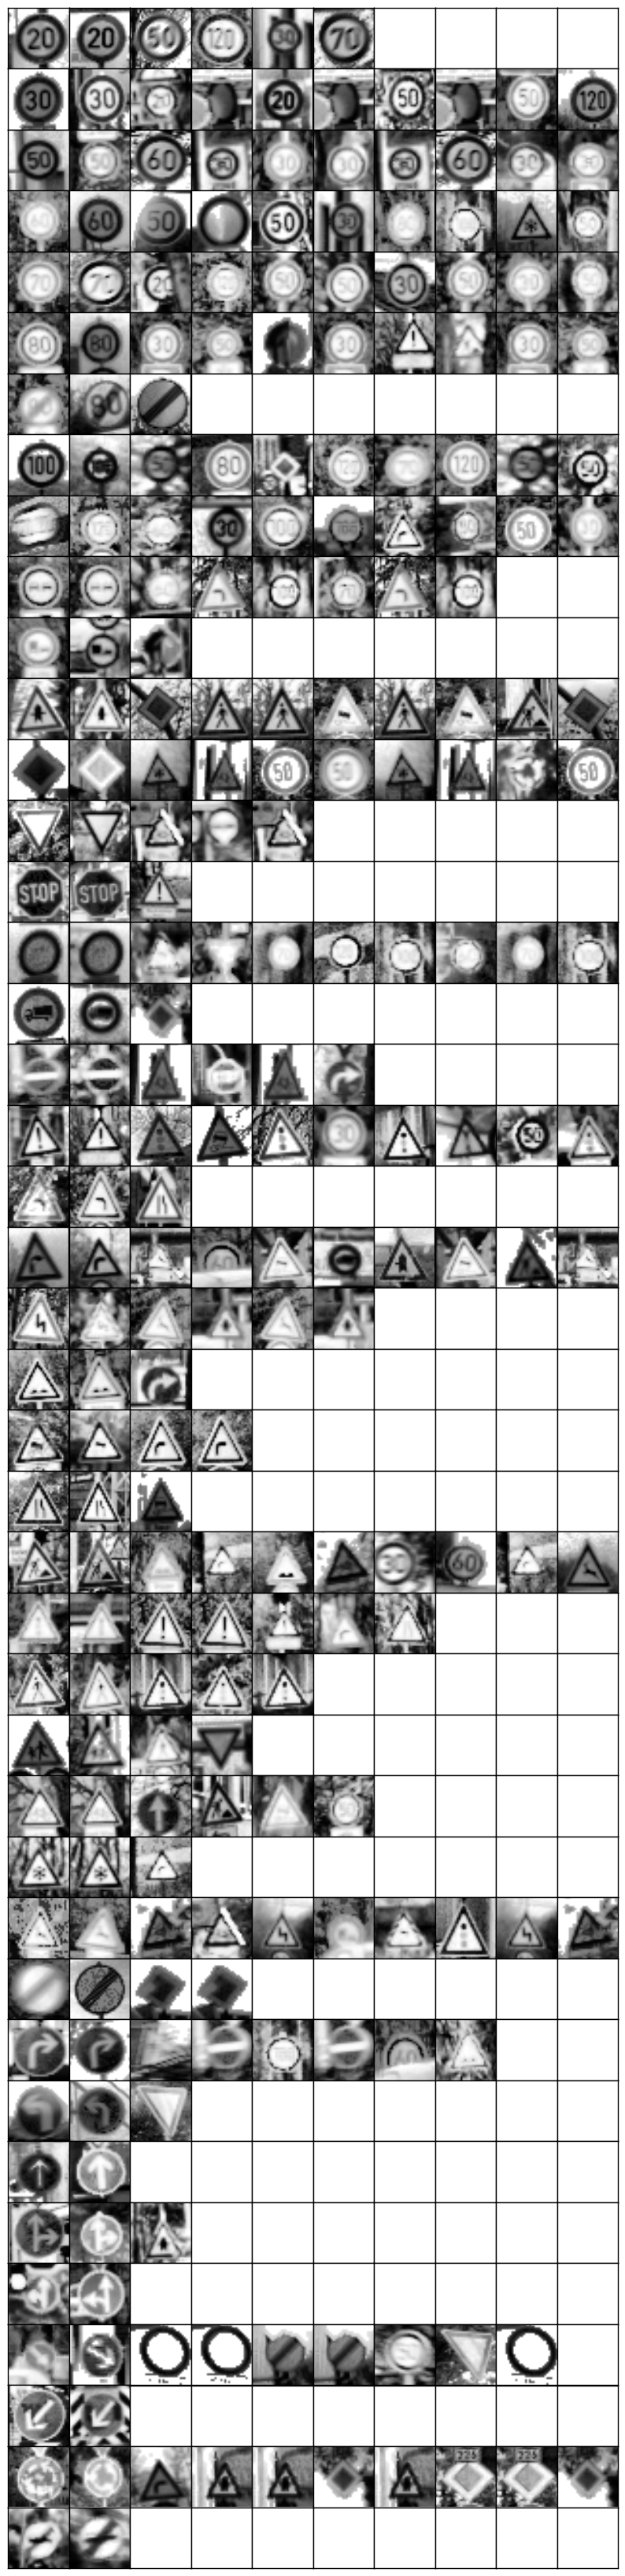

In [175]:
def plot_false_class(pred_class, image_class):
    idx = ( pred_class != image_class )
    plt.hist([image_class[idx]],bins=max(np.unique(image_class)))

def plot_true_class(pred_class, image_class):
    idx = ( pred_class == image_class )
    plt.hist([image_class[idx]],bins=max(np.unique(image_class)))

# sample a correctly classified from each class
# sample n incorrect from each class
# display in a column
def sample_misclassified(pred_class, image_class, n_sample_true = 2, n_sample_false = 8):
    n_classes = max(image_class)
    indices = np.arange(0,len(image_class))
    result = np.zeros(shape=[n_classes,n_sample_true + n_sample_false],dtype=int)
    for i in range(0,n_classes):
        bidx_t = np.array([ p==a and a==i for p, a in zip(pred_class, image_class) ])
        bidx_f = np.array([ p!=a and p==i for p, a in zip(pred_class, image_class) ])
        idx = indices[bidx_t]
        if len(idx) > 0 :
            sample_indices = np.random.choice(idx,n_sample_true)
            result[i,0:n_sample_true] = sample_indices
            idx = indices[bidx_f]
            if len(idx) > 0:
                n = min(len(idx), n_sample_false)
                sample_indices = np.random.choice(idx,n)
                result[i, n_sample_true:n_sample_true+n] = sample_indices
    
    return result

# Print out image in grid
def plot_image_grid(images, indices, grayscale = False):
    n_rows = indices.shape[0]
    n_cols = indices.shape[1]
    fig = plt.figure(figsize=(n_cols, n_rows))
    gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.0, hspace=0.0)
    for i, xy in enumerate(product(range(0,n_rows), range(0,n_cols))):
        ax = plt.subplot(gs[xy[0], xy[1]])
        idx = indices[xy[0], xy[1]]
        if idx > 0:
            if grayscale:
                ax.imshow(images[idx], cmap='gray')
            else:
                ax.imshow(images[idx])  
        ax.set_xticks([])
        ax.set_yticks([])
        
idx = sample_misclassified(y_pred, y_valid)
plot_image_grid(X_valid_gray, idx, grayscale = True)

We could train a deeper network - but I think it may be better to build a convolutional neural network.  I think we might get similar performance but quicker.

### Convnet

I am going to start with LeNet from the lecture.

First let's pull in helper functions to quickly define layers:

In [17]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def conv_layer(input,                  # previous layer.
                   num_input_channels, # depth of previous layer
                   filter_size,        # filter width/height
                   num_filters,        # number of filters
                   stride,             # stride size
                   padding):           # padding 'VALID' or 'SAME'
    
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, stride, stride, 1],
                         padding=padding)
    layer += biases
    return layer

def fully_connected_layer(input,              # previous layer.
                   num_inputs,                # number of inputs
                   num_outputs):              # number of outputs
    
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    return layer

def LeNet(x):
    # Convolution layer 1. The output shape should be 28x28x6.
    x=conv_layer(input=x, num_input_channels=1, filter_size=5, num_filters=24, stride=1, padding='VALID')
    # Activation 1. Your choice of activation function.
    x=tf.nn.relu(x)
    # Pooling layer 1. The output shape should be 14x14x6.
    x=tf.nn.max_pool(value=x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # Convolution layer 2. The output shape should be 10x10x16.
    x=conv_layer(input=x, num_input_channels=6, filter_size=5, num_filters=16, stride=1, padding='VALID')
    # Activation 2. Your choice of activation function.
    x=tf.nn.relu(x)
    # Pooling layer 2. The output shape should be 5x5x16.
    x=tf.nn.max_pool(value=x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # Flatten layer. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten, which is already imported for you.
    x=tf.contrib.layers.flatten(x)
    # Fully connected layer 1. This should have 120 outputs.
    x=fully_connected_layer(x, 400, 120)
    # Activation 3. Your choice of activation function.
    x=tf.nn.relu(x)
    # Fully connected layer 2. This should have 10 outputs.
    x=fully_connected_layer(x, 120, 10)
    # Return the result of the last fully connected layer.
    return x

  4%|▎         | 74/2000 [10:35<4:37:51,  8.66s/epochs]

Stopping no improvement for 25 epochs


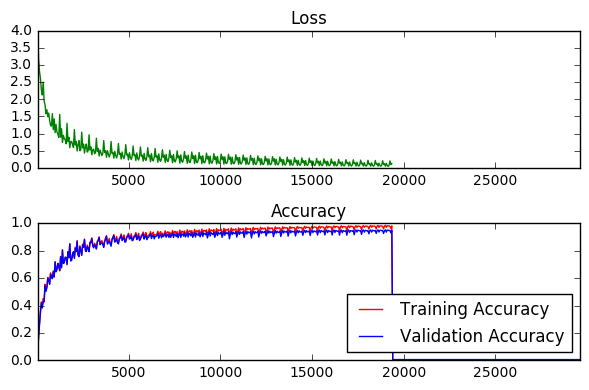

Validation accuracy at 0.945167064666748


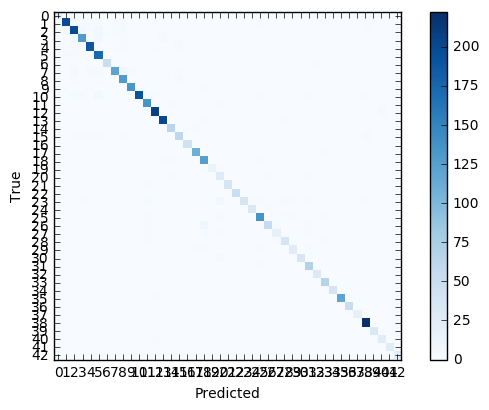

In [20]:
import math
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

epochs = 2000
batch_size = 100
learning_rate = 0.1

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# Early stopping parameters
early_stopping_rounds = 25

# For saving the tensorflow variables
saver = tf.train.Saver()

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(X_train_gray_flat)/batch_size))

    # Early stopping flags
    epoch_i = 0
    continue_training = True
    consider_stopping = False
    epochs_since_better = 0
    best_accuracy = 0.0
    
    with tqdm(range(epochs), unit='epochs') as pbar: 
        while epoch_i < epochs and continue_training:
            batch_i = 0
            while batch_i < batch_count and continue_training:

                # Get a batch of training features and labels
                batch_start = batch_i*batch_size
                batch_features = X_train_gray_flat[batch_start:batch_start + batch_size]
                batch_labels = train_labels[batch_start:batch_start + batch_size]

                # Run optimizer and get loss
                _, l = session.run(
                    [optimizer, loss],
                    feed_dict={features: batch_features, labels: batch_labels})

                # Log every 50 batches
                if not batch_i % log_batch_step:
                    # Calculate Training and Validation accuracy
                    training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                    validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                    # Log batches
                    previous_batch = batches[-1] if batches else 0
                    batches.append(log_batch_step + previous_batch)
                    loss_batch.append(l)
                    train_acc_batch.append(training_accuracy)
                    valid_acc_batch.append(validation_accuracy)

                batch_i += 1
                
            # Check accuracy against Validation data
            validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
            # Get predicted class
            y_pred = session.run(predicted_class, feed_dict=valid_feed_dict)

            # Early stopping?
            if validation_accuracy < best_accuracy:    
                if consider_stopping:
                    epochs_since_better += 1
                else:
                    consider_stopping = True
                    epochs_since_better = 1
            else:
                best_accuracy = validation_accuracy
                saver.save(session, "model_cnn.ckpt")
                consider_stopping = False

            if epochs_since_better > early_stopping_rounds:
                    print('Stopping no improvement for {} epochs'.format(early_stopping_rounds))
                    continue_training = False

            epoch_i += 1
            pbar.update(1)
        
    # Restore best model
    saver.restore(session, "model_cnn.ckpt")
    # Check accuracy against Validation data
    validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
    # Get predicted class
    y_pred = session.run(predicted_class, feed_dict=valid_feed_dict)
        
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_true=y_valid,
                          y_pred=y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, range(n_classes))
plt.yticks(tick_marks, range(n_classes))
plt.xlabel('Predicted')
plt.ylabel('True')

print('Validation accuracy at {}'.format(validation_accuracy))

Finally does the model perform well on test set?

What about on my own images from neighbourhood?

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [15]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [16]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [17]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [19]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [20]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.